# Assessment of Cosmic Ray Composition Estimation using Machine Learning

In [10]:
%matplotlib inline

import json
import os
from glob import glob
from warnings import catch_warnings, filterwarnings

import matplotlib.pyplot as plt
import numpy as np

from utils import get_event_parameters, get_training_assessment_cut, get_cuts

## USER SETTINGS TO ADJUST

In [11]:
# Edit this file path to point to the models folder containing .h5 and .npy files for each model.
ICETOP_CNN_DATA_DIR = os.getenv('ICETOP_CNN_DATA_DIR')
MODELS_FOLDER_PATH = os.path.join(ICETOP_CNN_DATA_DIR, 'models')

# Edit this file path to point to the simdata folder containing the simulation data.
SIMDATA_FOLDER_PATH = os.path.join(ICETOP_CNN_DATA_DIR, 'simdata')

# Option to change font size for all labels within this notebook
LABEL_PARAMS = {
    'fontsize':20
}

# The keys will be the names of the models you wish to analyze
# The values will be the nuclei to assess for each model
MODEL_NAMES_AND_NUCLEI = {
    'honor': 'pf',
    'perseverance': 'p'
}

In [12]:
# List available models

# Ensure that models folder has actually been found
assert os.path.exists(MODELS_FOLDER_PATH), f'ERROR: Could not find models folder. Path specified: {MODELS_FOLDER_PATH}'

model_list = glob(os.path.join(MODELS_FOLDER_PATH, '*.h5'))                     # Get all model .h5 files
model_list = [os.path.splitext(os.path.basename(m))[0] for m in model_list]     # Trim parent directories and file extension

param_list = glob(os.path.join(MODELS_FOLDER_PATH, '*.json'))                   # Get all parameter .json files
param_list = [os.path.splitext(os.path.basename(p))[0] for p in param_list]     # Trim parent directories and file extension

print('Available models:', sorted(set(model_list).intersection(param_list)))                  # Models that have both .h5 and .json files
print('\nModels without parameter files:', sorted(set(model_list).difference(param_list)))    # Models that have a .h5 file but no .json file

Available models: []

Models without parameter files: []


In [13]:
# Automatic intake of parameters from parameter files
# Builds a dictionary mapping model names to their corresponding PREP dictionary
model_parameters = {}

for model_name, assessment_nuclei in MODEL_NAMES_AND_NUCLEI.items():
    # Construct the full .npy model path
    model_path = os.path.join(MODELS_FOLDER_PATH, model_name, model_name + '.json')

    # Ensure that the model is found (no typos)
    if not os.path.exists(model_path):
        print(f'WARNING: Model {model_name} not found at {MODELS_FOLDER_PATH}')
        continue

    # Load model parameters and save into dictionary along with assessment nuclei
    with open(model_path, 'r') as f:
        model_parameters[model_name] = json.load(f)
    model_parameters[model_name].update({'assessment_nuclei': assessment_nuclei})
    
    # Print entry
    print(model_name, ':', model_parameters[model_name])

assert len(model_parameters), 'ERROR: No models selected for analysis!'

honor : {'infill': False, 'clc': True, 'sta5': False, 'q': None, 't': None, 't_shift': True, 't_clip': 0.0, 'normed': True, 'reco': 'plane', 'training_nuclei': 'phof', 'assessment_nuclei': 'pf'}
perseverance : {'infill': False, 'clc': True, 'sta5': False, 'q': None, 't': None, 't_shift': True, 't_clip': 0.0, 'normed': True, 'reco': 'plane', 'training_nuclei': 'phof', 'assessment_nuclei': 'p'}


In [14]:
# Load detector inputs and event parameters
# In its own cell because this can take a while
event_parameters = get_event_parameters(SIMDATA_FOLDER_PATH, composition='phof')

In [15]:
reconstructions = {}
cuts = {}

comp_conversion = {'p':1, 'h':4, 'o':16, 'f':56}

# Calculate reconstructed energies. This can take a bit (a few minutes), but should print out info on each model as it works
for model_name, model_prep in model_parameters.items():
    
    # Print model parameters as the different models predict
    print(f'Working on {model_name}...\n{model_prep}\n')

    # Load model prediction
    reconstruction = np.load(os.path.join(ICETOP_CNN_DATA_DIR, 'reconstructions', 'comp', model_name + '.npy'))
    
    # Load data cut
    cut = get_training_assessment_cut(event_parameters, 'assessment', model_prep)

    # Nuclei cut
    nuclei_to_assess = [comp_conversion[nuclei] for nuclei in model_prep['assessment_nuclei']]

    reconstruction = reconstruction[np.isin(event_parameters['comp'][cut], nuclei_to_assess)]
    cut *= np.isin(event_parameters['comp'], nuclei_to_assess)

    # Save data cut
    cuts[model_name] = cut
    
    # Save model prediction
    reconstructions[model_name] = np.argmax(reconstruction, axis=1)

Working on honor...
{'infill': False, 'clc': True, 'sta5': False, 'q': None, 't': None, 't_shift': True, 't_clip': 0.0, 'normed': True, 'reco': 'plane', 'training_nuclei': 'phof', 'assessment_nuclei': 'pf'}

Working on perseverance...
{'infill': False, 'clc': True, 'sta5': False, 'q': None, 't': None, 't_shift': True, 't_clip': 0.0, 'normed': True, 'reco': 'plane', 'training_nuclei': 'phof', 'assessment_nuclei': 'p'}



In [16]:
comp_table = { # HACK
    'p': {'weight': 1,  'alias': 0, 'name': 'proton', 'color': 'red'},
    'h': {'weight': 4,  'alias': 1, 'name': 'helium', 'color': 'orange'},
    'o': {'weight': 16, 'alias': 2, 'name': 'oxygen', 'color': 'green'},
    'f': {'weight': 56, 'alias': 3, 'name': 'iron',   'color': 'blue'},
}

cut_names = ['No Cut', 'Quality Cut']

In [17]:
# Basic Summary Statistics

for cut_name in cut_names:
    print(cut_name.upper().center(62)) # Max length of a summary statistic in current format
    for model_name, reconstructed_composition in reconstructions.items():
        model_cut = cuts[model_name]
        reco_cut, data_cut = get_cuts(model_cut, event_parameters, cut_name)
        print(f'Output for {model_name}:')
        for comp in MODEL_NAMES_AND_NUCLEI[model_name]:
            model_specific_comp = (event_parameters['comp'] == comp_table[comp]['weight'])[data_cut]
            num_model_specific_comp = sum(model_specific_comp)
            num_correct_guesses = sum((reconstructed_composition[reco_cut] == comp_table[comp]['alias']) & model_specific_comp)
            print(f'  Number of correct {comp_table[comp]["name"]} guesses: {num_correct_guesses} (Accuracy = {100*num_correct_guesses/num_model_specific_comp:.2f}%)')
            for c in MODEL_NAMES_AND_NUCLEI[model_name]:
                if c == comp or comp_table[c]['alias'] is None:
                    continue
                num_incorrect_guesses = sum((reconstructed_composition[reco_cut] == comp_table[c]['alias']) & model_specific_comp)
                print(f'    Number of {comp_table[comp]["name"]}s labeled as {comp_table[c]["name"]}: {num_incorrect_guesses} ({100*num_incorrect_guesses/num_model_specific_comp:.2f}%)')
    print()

                            NO CUT                            
Output for honor:
  Number of correct proton guesses: 20523 (Accuracy = 63.48%)
    Number of protons labeled as iron: 4073 (12.60%)
  Number of correct iron guesses: 14717 (Accuracy = 51.08%)
    Number of irons labeled as proton: 5931 (20.59%)
Output for perseverance:
  Number of correct proton guesses: 18255 (Accuracy = 56.46%)

                         QUALITY CUT                          
Output for honor:
  Number of correct proton guesses: 5312 (Accuracy = 63.87%)
    Number of protons labeled as iron: 851 (10.23%)
  Number of correct iron guesses: 4287 (Accuracy = 59.07%)
    Number of irons labeled as proton: 975 (13.44%)
Output for perseverance:
  Number of correct proton guesses: 4463 (Accuracy = 53.66%)



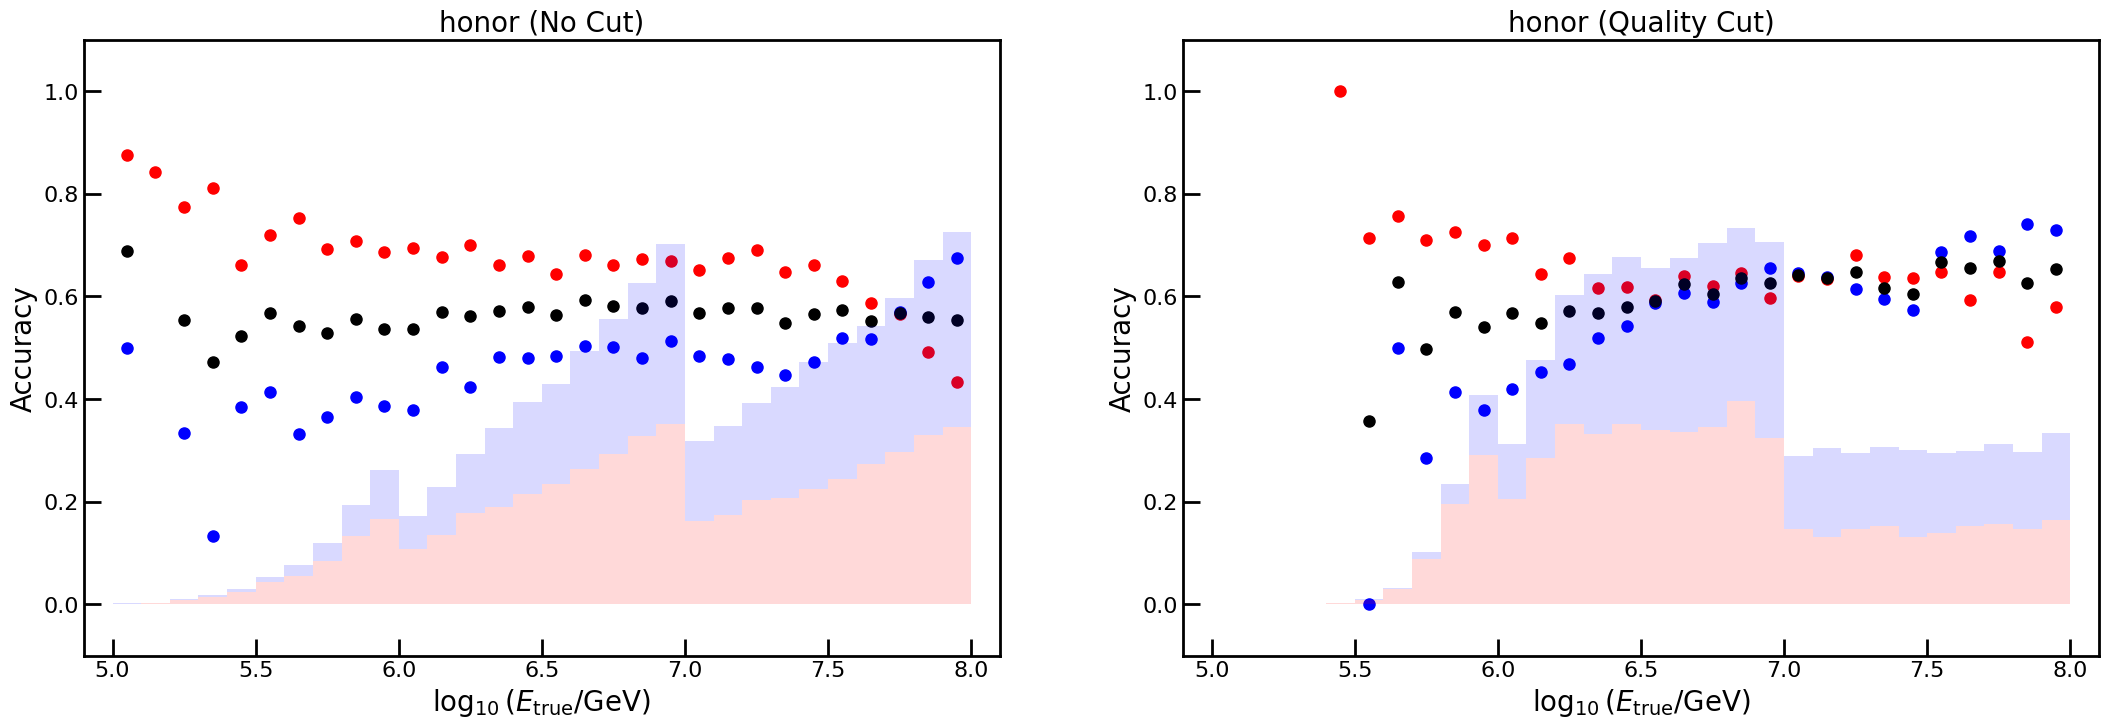

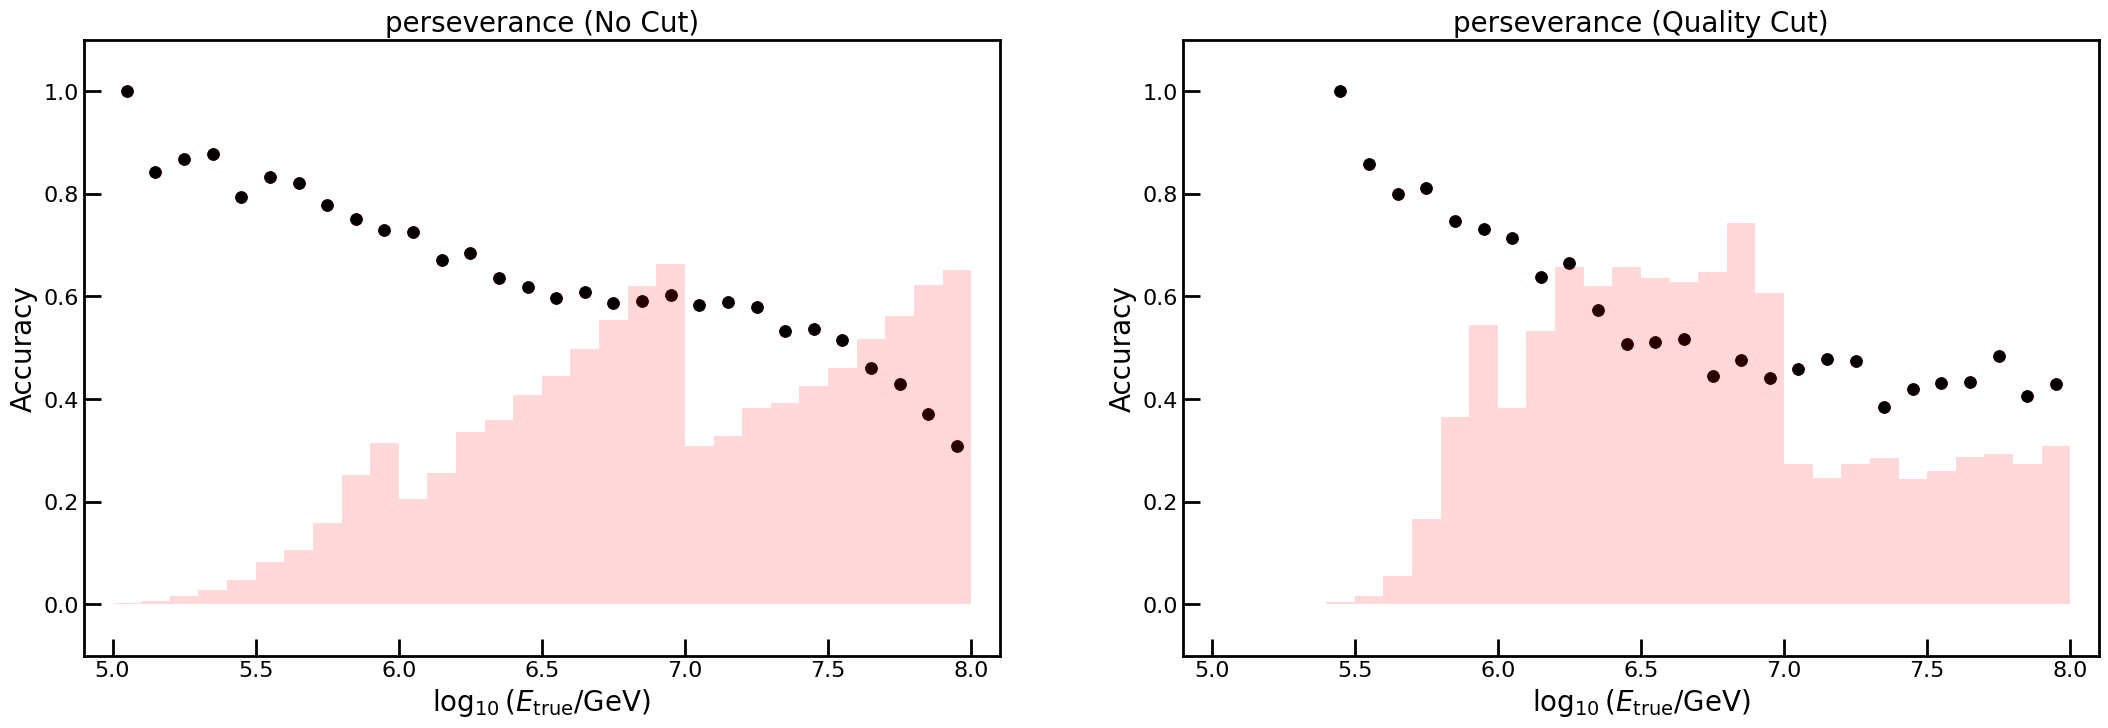

In [18]:
# Average Accuracy as a Function of Energy

bin_min, bin_max, inc = 5, 8, 0.1
num_bins = int((1/inc)*(bin_max-bin_min))
bin_edges = np.linspace(bin_min, bin_max, num_bins+1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

y_min, y_max = 0, 1
marker_size = 640*inc
ncols = len(cut_names)

for model_name, reconstructed_composition in reconstructions.items():
    fig, axs = plt.subplots(figsize=(13*ncols, 8), ncols=ncols)
    for i, cut_name in enumerate(cut_names):
        ax = axs[i]
        reco_cut, data_cut = get_cuts(cuts[model_name], event_parameters, cut_name)
        model_specific_energy = event_parameters['energy'][data_cut]
        binned_accuracies, bin_counts = [], []
        for comp in MODEL_NAMES_AND_NUCLEI[model_name]:
            model_specific_comp = (event_parameters['comp'] == comp_table[comp]['weight'])[data_cut].astype(int)
            binned_model_specific_comp = np.histogram(model_specific_energy, bins=bin_edges, weights=model_specific_comp)[0].astype(int)
            correct_guesses = (reconstructed_composition[reco_cut] == comp_table[comp]['alias']) & model_specific_comp
            binned_correct_guesses = np.histogram(model_specific_energy, bins=bin_edges, weights=correct_guesses)[0].astype(int)
            with catch_warnings(): # No values in a particular bin means doing a 0/0 division
                filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered in divide')
                binned_accuracy = binned_correct_guesses / binned_model_specific_comp
            binned_accuracies.append(binned_accuracy)
            bin_counts.append(binned_model_specific_comp)
            ax.scatter(bin_centers, binned_accuracy, s=marker_size, color=comp_table[comp]['color'])
        ax.scatter(bin_centers, np.mean(binned_accuracies, axis=0), s=marker_size, color='black')
        ax.hist(np.repeat(bin_edges[:-1], len(MODEL_NAMES_AND_NUCLEI[model_name])).reshape(-1, len(MODEL_NAMES_AND_NUCLEI[model_name])), bins=bin_edges, density=True, weights=np.asarray(bin_counts).transpose(), histtype='barstacked', color=[comp_table[c]['color'] for c in MODEL_NAMES_AND_NUCLEI[model_name]], alpha=0.15)
        ax.set_title(f'{model_name} ({cut_name})', fontsize=20)
        ax.set_xlabel(r'$\log_{10}(E_{\mathrm{true}}/\mathrm{GeV})$', fontsize=20)
        ax.set_ylabel('Accuracy', fontsize=20)
        ax.set_xlim(bin_min-inc, bin_max+inc)
        ax.set_ylim(y_min-inc, y_max+inc)
        ax.tick_params(axis='both', direction='in', length=12, width=2, labelsize=16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
    plt.show()
            